# 保险索赔的特威迪回归
此示例说明了在法国汽车第三方责任索赔数据集上使用泊松、伽玛和 Tweedie 回归，并受到 R 教程1 的启发。

在此数据集中，每个样本对应于一份保险单，即保险公司和个人（保单持有人）之间的合同。可用功能包括驾驶员年龄，车辆年龄，车辆功率等。

一些定义：索赔是投保人向保险公司提出的赔偿保险所涵盖的损失的请求。索赔金额是保险公司必须支付的金额。风险敞口是给定保单的保险范围的持续时间，以年为单位。

在这里，我们的目标是预测每个风险单位的总索赔金额的预期价值，即平均值，也称为纯溢价。

有几种可能性可以做到这一点，其中两种是：

1. 将具有 Poisson 分布的声明数和每个声明的平均索赔金额（也称为严重性）建模为 Gamma 分布，并将两者的预测相乘，以获得总索赔金额。

2. 直接对每次暴露的总索赔金额进行建模，通常使用 Tweedie 功率\（p \in （1， 2）\）的 Tweedie 分布。

在此示例中，我们将说明这两种方法。我们首先定义一些用于加载数据和可视化结果的帮助器函数。

A. Noll，R. Salzmann和M.V. Wuthrich，案例研究：
法国汽车第三方责任索赔（2018年11月8日）。doi：10.2139/ssrn.3164764

In [12]:
# Authors: Christian Lorentzen <lorentzen.ch@gmail.com>
#          Roman Yurchak <rth.yurchak@gmail.com>
#          Olivier Grisel <olivier.grisel@ensta.org>
# License: BSD 3 clause

from functools import partial

import numpy as np
import matplotlib.pyplot as plt
plt.style.use(plt.style.available[0])
import pandas as pd

from sklearn.datasets import fetch_openml
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import PoissonRegressor, GammaRegressor
from sklearn.linear_model import TweedieRegressor
from sklearn.metrics import mean_tweedie_deviance
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer

from sklearn.metrics import mean_absolute_error, mean_squared_error, auc


def load_mtpl2(n_samples=100000):
    """获取法国汽车第三方责任索赔数据集。
    参数
        ----------
    n_samples: int,默认= 100000
    选择的样本数量(为了更快的运行时间)。有一个完整的数据库
    678013个样本。
    """
    # freMTPL2freq dataset from https://www.openml.org/d/41214 数据集freMTPL2freq包含677，991个电机第三方责任保单的风险特征（主要在一年内观察到）
    df_freq = fetch_openml(data_id=41214, as_frame=True)["data"]
    df_freq["IDpol"] = df_freq["IDpol"].astype(int)
    df_freq.set_index("IDpol", inplace=True)

    # freMTPL2sev dataset from https://www.openml.org/d/41215
    df_sev = fetch_openml(data_id=41215, as_frame=True)["data"]

    # sum ClaimAmount over identical IDs
    df_sev = df_sev.groupby("IDpol").sum()

    df = df_freq.join(df_sev, how="left")
    df["ClaimAmount"].fillna(0, inplace=True)

    # 结束字符串字段
    for column_name in df.columns[df.dtypes.values == object]:
        df[column_name] = df[column_name].str.strip("'")
    return df.iloc[:n_samples]


def plot_obs_pred(
    df,
    feature,
    weight,
    observed,
    predicted,
    y_label=None,
    title=None,
    ax=None,
    fill_legend=False,
):
    """观察和预测的情节-聚合每个功能水平。

    参数
    ----------
    df : DataFrame
        输入数据
    feature: str
        要绘制的特性的列名df
    weight : str
        带有权重或曝光值的df的列名称
    observed : str
        观察目标的列名为df
    predicted : DataFrame
        一个数据帧，具有与df相同的索引，具有预测的目标
    fill_legend : bool, default=False
        是否显示fill_between legend
    """
    # 根据特征级别聚合观察和预测的变量
    df_ = df.loc[:, [feature, weight]].copy()
    df_["observed"] = df[observed] * df[weight]
    df_["predicted"] = predicted * df[weight]
    df_ = (
        df_.groupby([feature])[[weight, "observed", "predicted"]]
        .sum()
        .assign(observed=lambda x: x["observed"] / x[weight])
        .assign(predicted=lambda x: x["predicted"] / x[weight])
    )

    ax = df_.loc[:, ["observed", "predicted"]].plot(style=".", ax=ax)
    y_max = df_.loc[:, ["observed", "predicted"]].values.max() * 0.8
    p2 = ax.fill_between(
        df_.index,
        0,
        y_max * df_[weight] / df_[weight].values.max(),
        color="g",
        alpha=0.1,
    )
    if fill_legend:
        ax.legend([p2], ["{} distribution".format(feature)])
    ax.set(
        ylabel=y_label if y_label is not None else None,
        title=title if title is not None else "Train: Observed vs Predicted",
    )


def score_estimator(
    estimator,
    X_train,
    X_test,
    df_train,
    df_test,
    target,
    weights,
    tweedie_powers=None,
):
    """在列车和测试集上用不同的指标评估一个估计量"""

    metrics = [
        ("D² explained", None),  # 使用默认评分器，如果它存在
        ("mean abs. error", mean_absolute_error),
        ("mean squared error", mean_squared_error),
    ]
    if tweedie_powers:
        metrics += [
            (
                "mean Tweedie dev p={:.4f}".format(power),
                partial(mean_tweedie_deviance, power=power),
            )
            for power in tweedie_powers
        ]

    res = []
    for subset_label, X, df in [
        ("train", X_train, df_train),
        ("test", X_test, df_test),
    ]:
        y, _weights = df[target], df[weights]
        for score_label, metric in metrics:
            if isinstance(estimator, tuple) and len(estimator) == 2:
                # 对由频率模型和严重性模型的乘积组成的模型进行评分。
                est_freq, est_sev = estimator
                y_pred = est_freq.predict(X) * est_sev.predict(X)
            else:
                y_pred = estimator.predict(X)

            if metric is None:
                if not hasattr(estimator, "score"):
                    continue
                score = estimator.score(X, y, sample_weight=_weights)
            else:
                score = metric(y, y_pred, sample_weight=_weights)

            res.append({"subset": subset_label, "metric": score_label, "score": score})

    res = (
        pd.DataFrame(res)
        .set_index(["metric", "subset"])
        .score.unstack(-1)
        .round(4)
        .loc[:, ["train", "test"]]
    )
    return res

## 加载数据集、基本特征提取和目标定义
我们通过将包含声明数 （） 的 freMTPL2freq 表与包含相同策略 id （） 的声明金额 （） 的 freMTPL2sev 表联接来构造 freMTPL2 数据集。ClaimNbClaimAmountIDpol

In [13]:
df = load_mtpl2(n_samples=60000)

       ClaimNb  Exposure Area  VehPower  VehAge  DrivAge  BonusMalus VehBrand  \
IDpol                                                                           
139        1.0      0.75    F       7.0     1.0     61.0        50.0      B12   
190        1.0      0.14    B      12.0     5.0     50.0        60.0      B12   
414        1.0      0.14    E       4.0     0.0     36.0        85.0      B12   
424        2.0      0.62    F      10.0     0.0     51.0       100.0      B12   
463        1.0      0.31    A       5.0     0.0     45.0        50.0      B12   

        VehGas  Density Region  ClaimAmount   PurePremium  Frequency  \
IDpol                                                                  
139    Regular  27000.0    R11       303.00    404.000000   1.333333   
190     Diesel     56.0    R25      1981.84  14156.000000   7.142857   
414    Regular   4792.0    R11      1456.55  10403.928571   7.142857   
424    Regular  27000.0    R11     10834.00  17474.193548   3.225806   


C:\ProgramData\Anaconda3\envs\py39\lib\site-packages\sklearn\preprocessing\_discretization.py:236: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


In [29]:
# df.head(3)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15000 entries, 6349 to 112235
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   ClaimNb         15000 non-null  float64 
 1   Exposure        15000 non-null  float64 
 2   Area            15000 non-null  category
 3   VehPower        15000 non-null  float64 
 4   VehAge          15000 non-null  float64 
 5   DrivAge         15000 non-null  float64 
 6   BonusMalus      15000 non-null  float64 
 7   VehBrand        15000 non-null  category
 8   VehGas          15000 non-null  object  
 9   Density         15000 non-null  float64 
 10  Region          15000 non-null  category
 11  ClaimAmount     15000 non-null  float64 
 12  PurePremium     15000 non-null  float64 
 13  Frequency       15000 non-null  float64 
 14  AvgClaimAmount  15000 non-null  float64 
dtypes: category(3), float64(11), object(1)
memory usage: 2.0+ MB


In [ ]:
# 注意:过滤掉金额为零的索赔，因为严重性模型要求严格的正目标值。
df.loc[(df["ClaimAmount"] == 0) & (df["ClaimNb"] >= 1), "ClaimNb"] = 0

# 正确的不合理的观察(可能是数据错误)和一些特别大的索赔金额
df["ClaimNb"] = df["ClaimNb"].clip(upper=4)
df["Exposure"] = df["Exposure"].clip(upper=1)
df["ClaimAmount"] = df["ClaimAmount"].clip(upper=200000)

log_scale_transformer = make_pipeline(
    FunctionTransformer(func=np.log), StandardScaler()
)

column_trans = ColumnTransformer(
    [
        ("binned_numeric", KBinsDiscretizer(n_bins=10), ["VehAge", "DrivAge"]),
        (
            "onehot_categorical",
            OneHotEncoder(),
            ["VehBrand", "VehPower", "VehGas", "Region", "Area"],
        ),
        ("passthrough_numeric", "passthrough", ["BonusMalus"]),
        ("log_scaled_numeric", log_scale_transformer, ["Density"]),
    ],
    remainder="drop",
)
X = column_trans.fit_transform(df)

# 保险公司对纯保费(Pure Premium)模型感兴趣，纯保费是其投资组合中每个投保人的每单位风险的预期总理赔金额:
df["PurePremium"] = df["ClaimAmount"] / df["Exposure"]

# 这可以通过一个2步建模来间接近似:频率乘以平均索赔金额的乘积:
df["Frequency"] = df["ClaimNb"] / df["Exposure"]
df["AvgClaimAmount"] = df["ClaimAmount"] / np.fmax(df["ClaimNb"], 1)

with pd.option_context("display.max_columns", 15):
    print(df[df.ClaimAmount > 0].head())

## 频率模型 – 泊松分布
声明数 （） 是正整数（包括 0）。因此，此目标可以通过泊松分布进行建模。然后，假设它是在给定时间间隔（以年为单位）内以恒定速率发生的离散事件的数量。在这里，我们对频率进行建模，该频率仍然是（缩放的）泊松分布，并用作 。ClaimNbExposurey = ClaimNb / ExposureExposuresample_weight

In [14]:
df_train, df_test, X_train, X_test = train_test_split(df, X, random_state=0)

# 通过拟牛顿求解器l-BFGS最小化训练集上的泊松偏差来估计模型参数。
# 有些特征是共线的，我们使用弱惩罚来避免数值问题。
glm_freq = PoissonRegressor(alpha=1e-3, max_iter=400)
glm_freq.fit(X_train, df_train["Frequency"], sample_weight=df_train["Exposure"])

scores = score_estimator(
    glm_freq,
    X_train,
    X_test,
    df_train,
    df_test,
    target="Frequency",
    weights="Exposure",
)
print("Evaluation of PoissonRegressor on target Frequency")
print(scores)

Evaluation of PoissonRegressor on target Frequency
subset               train    test
metric                            
D² explained        0.0590  0.0579
mean abs. error     0.1706  0.1661
mean squared error  0.3041  0.3043


我们可以直观地比较观察到和预测的值，这些值由驾驶员年龄（），车辆年龄（）和保险奖金/恶意（）汇总。DrivAgeVehAgeBonusMalus

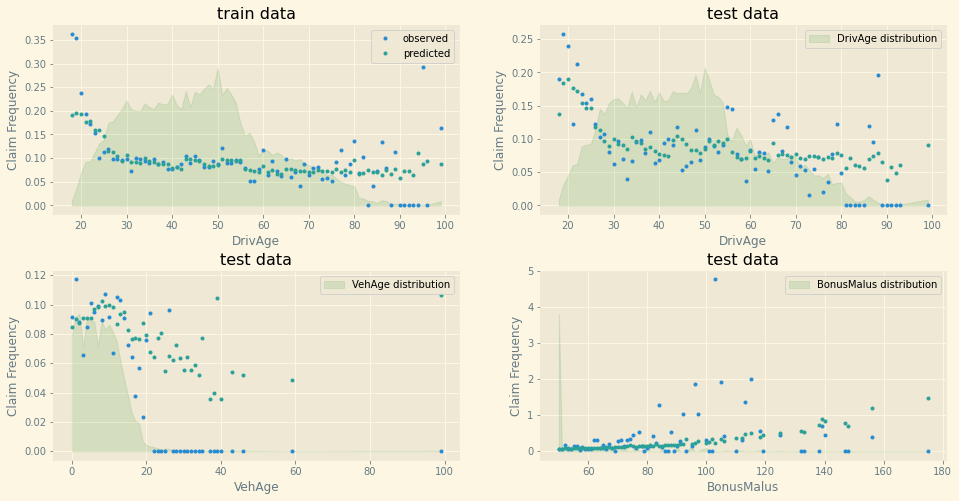

In [15]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(16, 8))
fig.subplots_adjust(hspace=0.3, wspace=0.2)

plot_obs_pred(
    df=df_train,
    feature="DrivAge",
    weight="Exposure",
    observed="Frequency",
    predicted=glm_freq.predict(X_train),
    y_label="Claim Frequency",
    title="train data",
    ax=ax[0, 0],
)

plot_obs_pred(
    df=df_test,
    feature="DrivAge",
    weight="Exposure",
    observed="Frequency",
    predicted=glm_freq.predict(X_test),
    y_label="Claim Frequency",
    title="test data",
    ax=ax[0, 1],
    fill_legend=True,
)

plot_obs_pred(
    df=df_test,
    feature="VehAge",
    weight="Exposure",
    observed="Frequency",
    predicted=glm_freq.predict(X_test),
    y_label="Claim Frequency",
    title="test data",
    ax=ax[1, 0],
    fill_legend=True,
)

plot_obs_pred(
    df=df_test,
    feature="BonusMalus",
    weight="Exposure",
    observed="Frequency",
    predicted=glm_freq.predict(X_test),
    y_label="Claim Frequency",
    title="test data",
    ax=ax[1, 1],
    fill_legend=True,
)

根据观测到的数据，30岁以下的驾驶员的事故发生频率较高，并且与变量呈正相关。我们的模型能够正确模拟这种行为。BonusMalus

## 严重性模型 - 伽玛分布
平均索赔金额或严重性 （） 可以根据经验证明大致遵循 Gamma 分布。我们针对严重程度拟合 GLM 模型，该模型具有与频率模型相同的特征。AvgClaimAmount

注意：

+ 我们筛选出 Gamma 分布对\（（0， \infty）\）的支持，而不是\（[0， \infty）\）。ClaimAmount == 0

+ 我们使用"作为包含多个声明的策略"。ClaimNbsample_weight

In [16]:
mask_train = df_train["ClaimAmount"] > 0
mask_test = df_test["ClaimAmount"] > 0

glm_sev = GammaRegressor(alpha=10.0, max_iter=10000)

glm_sev.fit(
    X_train[mask_train.values],
    df_train.loc[mask_train, "AvgClaimAmount"],
    sample_weight=df_train.loc[mask_train, "ClaimNb"],
)

scores = score_estimator(
    glm_sev,
    X_train[mask_train.values],
    X_test[mask_test.values],
    df_train[mask_train],
    df_test[mask_test],
    target="AvgClaimAmount",
    weights="ClaimNb",
)
print("Evaluation of GammaRegressor on target AvgClaimAmount")
print(scores)

Evaluation of GammaRegressor on target AvgClaimAmount
subset                     train          test
metric                                        
D² explained        4.300000e-03 -1.380000e-02
mean abs. error     1.699197e+03  2.027923e+03
mean squared error  4.548147e+07  6.094863e+07


在这里，测试数据的分数需要谨慎，因为它们比训练数据差得多，尽管有很强的正则化，但它们表明过度拟合。

请注意，生成的模型是每个索赔的平均索赔金额。因此，它以至少有一个索赔为条件，并且不能用于预测每份保单的平均索赔金额。

In [17]:
print(
    "Mean AvgClaim Amount per policy:              %.2f "
    % df_train["AvgClaimAmount"].mean()
)
print(
    "Mean AvgClaim Amount | NbClaim > 0:           %.2f"
    % df_train["AvgClaimAmount"][df_train["AvgClaimAmount"] > 0].mean()
)
print(
    "Predicted Mean AvgClaim Amount | NbClaim > 0: %.2f"
    % glm_sev.predict(X_train).mean()
)

Mean AvgClaim Amount per policy:              97.89 
Mean AvgClaim Amount | NbClaim > 0:           1899.60
Predicted Mean AvgClaim Amount | NbClaim > 0: 1884.40


我们可以直观地比较观察到的值和预测值，这些值是针对驾驶员年龄（）聚合的。DrivAge

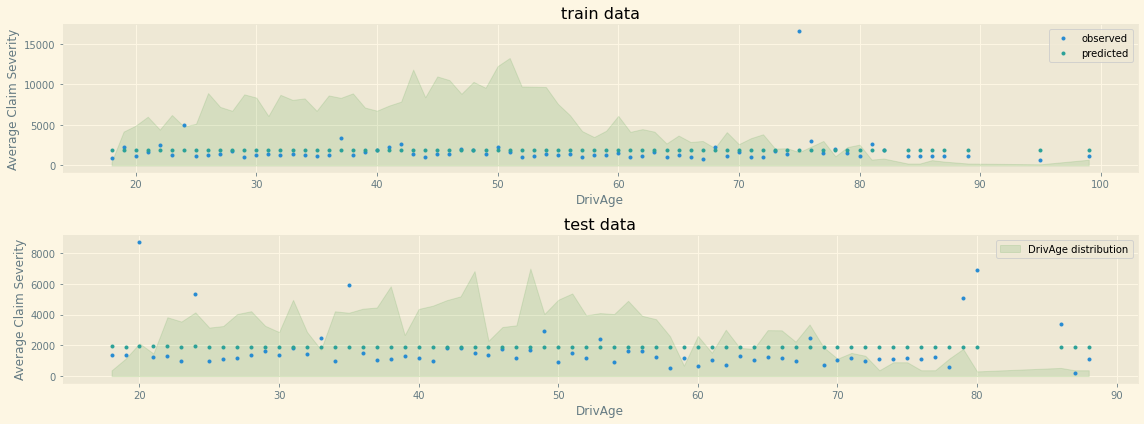

In [18]:
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(16, 6))

plot_obs_pred(
    df=df_train.loc[mask_train],
    feature="DrivAge",
    weight="Exposure",
    observed="AvgClaimAmount",
    predicted=glm_sev.predict(X_train[mask_train.values]),
    y_label="Average Claim Severity",
    title="train data",
    ax=ax[0],
)

plot_obs_pred(
    df=df_test.loc[mask_test],
    feature="DrivAge",
    weight="Exposure",
    observed="AvgClaimAmount",
    predicted=glm_sev.predict(X_test[mask_test.values]),
    y_label="Average Claim Severity",
    title="test data",
    ax=ax[1],
    fill_legend=True,
)
plt.tight_layout()

总体而言，驾驶员年龄（）对索赔严重性的影响很小，无论是在观察数据还是预测数据中。DrivAge

通过产品模型与单个TweedieRegressor进行纯高级建模
如导言所述，通过严重性模型的预测，可以将每单位暴露的总索赔额建模为频率模型预测的乘积。

或者，可以使用唯一的化合物泊松伽马广义线性模型（具有对数链接函数）直接对总损耗进行建模。此模型是具有"power"参数\（p \in （1， 2）\）的 Tweedie GLM 的一个特例。在这里，我们将 Tweedie 模型的参数固定为有效范围内的某个任意值 （1.9）。理想情况下，通过最小化 Tweedie 模型的负对数似然，通过网格搜索来选择此值，但不幸的是，当前的实现（尚未）允许这样做。power

我们将比较这两种方法的性能。为了量化两个模型的性能，可以计算训练的平均偏差，并假设总索赔额的化合物泊松-伽马分布，则测试数据。这等效于参数介于 1 和 2 之间的 Tweedie 分布。power

sklearn.metrics.mean_tweedie_deviance取决于参数。由于我们不知道参数的真实值，我们在这里计算可能值网格的均值偏差，并并排比较模型，即我们在相同的值上比较它们。理想情况下，我们希望一个模型将始终优于另一个模型，无论 .powerpowerpowerpower

In [22]:
glm_pure_premium = TweedieRegressor(power=1.9, alpha=0.1, max_iter=10000)
glm_pure_premium.fit(
    X_train, df_train["PurePremium"], sample_weight=df_train["Exposure"]
)

tweedie_powers = [1.5, 1.7, 1.8, 1.9, 1.99, 1.999, 1.9999]

scores_product_model = score_estimator(
    (glm_freq, glm_sev),
    X_train,
    X_test,
    df_train,
    df_test,
    target="PurePremium",
    weights="Exposure",
    tweedie_powers=tweedie_powers,
)

scores_glm_pure_premium = score_estimator(
    glm_pure_premium,
    X_train,
    X_test,
    df_train,
    df_test,
    target="PurePremium",
    weights="Exposure",
    tweedie_powers=tweedie_powers,
)

scores = pd.concat(
    [scores_product_model, scores_glm_pure_premium],
    axis=1,
    sort=True,
    keys=("Product Model", "TweedieRegressor"),
)
print("Evaluation of the Product Model and the Tweedie Regressor on target PurePremium")
with pd.option_context("display.expand_frame_repr", False):
    print(scores)

Evaluation of the Product Model and the Tweedie Regressor on target PurePremium
                          Product Model               TweedieRegressor              
subset                            train          test            train          test
metric                                                                              
D² explained                        NaN           NaN     2.550000e-02  2.480000e-02
mean Tweedie dev p=1.5000  8.217450e+01  8.637390e+01     7.960780e+01  8.618740e+01
mean Tweedie dev p=1.7000  3.833510e+01  3.919480e+01     3.737390e+01  3.917460e+01
mean Tweedie dev p=1.8000  3.106770e+01  3.148200e+01     3.047890e+01  3.148130e+01
mean Tweedie dev p=1.9000  3.396160e+01  3.420290e+01     3.360070e+01  3.420830e+01
mean Tweedie dev p=1.9900  1.989237e+02  1.996400e+02     1.986911e+02  1.996461e+02
mean Tweedie dev p=1.9990  1.886428e+03  1.892747e+03     1.886206e+03  1.892753e+03
mean Tweedie dev p=1.9999  1.876452e+04  1.882692e+04     1.876430e+04

在此示例中，两种建模方法都生成了可比较的性能指标。由于实现原因，解释方差\（D^2\）的百分比不适用于产品模型。

此外，我们还可以通过比较测试和训练子集上观察到的和预测的总索赔金额来验证这些模型。我们看到，平均而言，两个模型都倾向于低估总声明（但这种行为取决于正则化的数量）。

In [20]:
res = []
for subset_label, X, df in [
    ("train", X_train, df_train),
    ("test", X_test, df_test),
]:
    exposure = df["Exposure"].values
    res.append(
        {
            "subset": subset_label,
            "observed": df["ClaimAmount"].values.sum(),
            "predicted, frequency*severity model": np.sum(
                exposure * glm_freq.predict(X) * glm_sev.predict(X)
            ),
            "predicted, tweedie, power=%.2f"
            % glm_pure_premium.power: np.sum(exposure * glm_pure_premium.predict(X)),
        }
    )

print(pd.DataFrame(res).set_index("subset").T)

subset                                      train          test
observed                             4.577616e+06  1.725665e+06
predicted, frequency*severity model  4.564132e+06  1.494916e+06
predicted, tweedie, power=1.90       4.451405e+06  1.431933e+06


最后，我们可以使用累积索赔图比较这两个模型：对于每个模型，保单持有人按从最安全到最危险的顺序进行排名，并在y轴上绘制观察到的总累积索赔的比例。此图通常称为模型的有序洛伦兹曲线。

基尼系数（基于曲线下的面积）可用作模型选择指标，以量化模型对保单持有人进行排名的能力。请注意，此指标并不反映模型根据索赔总额的绝对值进行准确预测的能力，而仅反映作为排名指标的相对金额。

这两种模型都能够通过风险性对保单持有人进行排名，这些风险明显优于偶然性，尽管由于预测问题的自然难度，它们也远非完美。

请注意，基尼指数仅表征模型的排名表现，而不表征其校准：预测的任何单调变换都会使模型的基尼指数保持不变。

最后，应该强调的是，直接拟合纯溢价的化合物泊松伽玛模型在操作上更容易开发和维护，因为它由单个scikit-learn估计器组成，而不是一对模型，每个模型都有自己的一组超参数。

[]

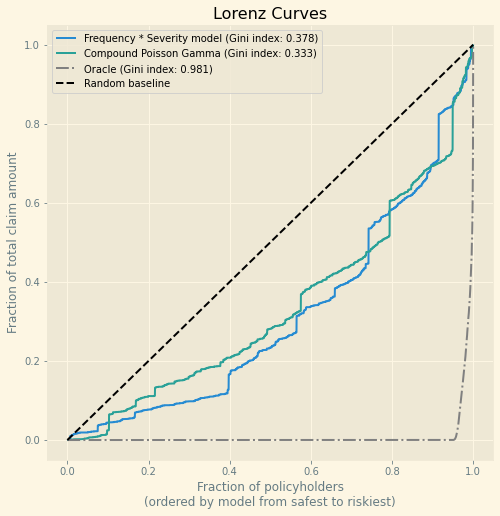

In [21]:
def lorenz_curve(y_true, y_pred, exposure):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    exposure = np.asarray(exposure)

    # 通过增加预测风险订购样品:
    ranking = np.argsort(y_pred)
    ranked_exposure = exposure[ranking]
    ranked_pure_premium = y_true[ranking]
    cumulated_claim_amount = np.cumsum(ranked_pure_premium * ranked_exposure)
    cumulated_claim_amount /= cumulated_claim_amount[-1]
    cumulated_samples = np.linspace(0, 1, len(cumulated_claim_amount))
    return cumulated_samples, cumulated_claim_amount


fig, ax = plt.subplots(figsize=(8, 8))

y_pred_product = glm_freq.predict(X_test) * glm_sev.predict(X_test)
y_pred_total = glm_pure_premium.predict(X_test)

for label, y_pred in [
    ("Frequency * Severity model", y_pred_product),
    ("Compound Poisson Gamma", y_pred_total),
]:
    ordered_samples, cum_claims = lorenz_curve(
        df_test["PurePremium"], y_pred, df_test["Exposure"]
    )
    gini = 1 - 2 * auc(ordered_samples, cum_claims)
    label += " (Gini index: {:.3f})".format(gini)
    ax.plot(ordered_samples, cum_claims, linestyle="-", label=label)

# Oracle model: y_pred == y_test
ordered_samples, cum_claims = lorenz_curve(
    df_test["PurePremium"], df_test["PurePremium"], df_test["Exposure"]
)
gini = 1 - 2 * auc(ordered_samples, cum_claims)
label = "Oracle (Gini index: {:.3f})".format(gini)
ax.plot(ordered_samples, cum_claims, linestyle="-.", color="gray", label=label)

# Random baseline
ax.plot([0, 1], [0, 1], linestyle="--", color="black", label="Random baseline")
ax.set(
    title="Lorenz Curves",
    xlabel="Fraction of policyholders\n(ordered by model from safest to riskiest)",
    ylabel="Fraction of total claim amount",
)
ax.legend(loc="upper left")
plt.plot()